[01/100] NLL=103.622
[02/100] NLL=74.491
[03/100] NLL=45.744
[04/100] NLL=122.192
[05/100] NLL=52.818
[06/100] NLL=30.314
[07/100] NLL=31.934
[08/100] NLL=163.945
[09/100] NLL=31.925
[10/100] NLL=52.212
[11/100] NLL=49.126
[12/100] NLL=50.651
[13/100] NLL=101.278
[14/100] NLL=106.023
[15/100] NLL=75.341
[16/100] NLL=78.861
[17/100] NLL=41.388
[18/100] NLL=54.986
[19/100] NLL=30.234
[20/100] NLL=97.899
[21/100] NLL=100.228
[22/100] NLL=104.933
[23/100] NLL=184.453
[24/100] NLL=29.740
[25/100] NLL=77.972
[26/100] NLL=85.034
[27/100] NLL=113.054
[28/100] NLL=98.328
[29/100] NLL=71.046
[30/100] NLL=98.120
[31/100] NLL=132.868
[32/100] NLL=42.045
[33/100] NLL=99.042
[34/100] NLL=107.147
[35/100] NLL=72.242
[36/100] NLL=100.916
[37/100] NLL=93.576
[38/100] NLL=98.988
[39/100] NLL=169.047
[40/100] NLL=86.575
[41/100] NLL=61.815
[42/100] NLL=34.103
[43/100] NLL=121.155
[44/100] NLL=57.692
[45/100] NLL=89.889
[46/100] NLL=50.162
[47/100] NLL=42.179
[48/100] NLL=47.190
[49/100] NLL=95.426
[50/10

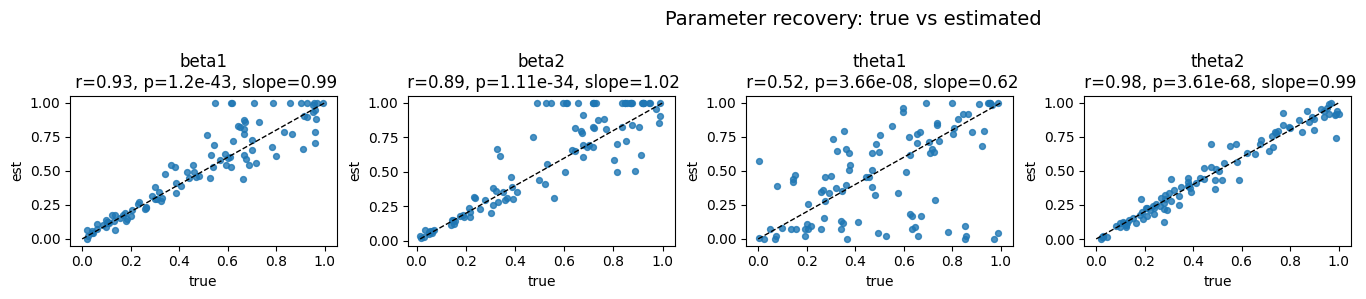

In [1]:
import loss4arbitration_fit as agent
from loss4arbitration_fit import two_stage

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt


from fit_functions import fd, nll

# ====== 可调参数 ======
N_RECOVER   = 100      # 采样多少组 θ_true（先小点，确认流程；稳了再提到 100）
N_TRIALS    = 150     # 每组模拟的 trial 数
N_RESTARTS  = 80      # 每组拟合的重启次数（越大越稳，越慢）
SEED_BASE   = 2025    # 总随机种子
SAVE_PREFIX = './PKL_DATA/fitdata/recovery_'  # 输出前缀
# =====================

rng_global = np.random.RandomState(SEED_BASE)

# --- 1) 小工具：从 pbnds 里均匀采样一组参数字典 ---
def sample_theta_from_pbnds():
    pnames = agent.MB.p_name
    pbnds  = agent.MB.pbnds
    vec = [rng_global.uniform(lo, hi) for (lo, hi) in pbnds]
    return {k: float(v) for k, v in zip(pnames, vec)}, np.array(vec, dtype=float)

# --- 2) 模拟出 nll 需要的 DataFrame（列：g,p,s0,a1,s1,a2,s2,r2） ---

def sim(agent_fn, params, n_episode=150, seed=873):
   
    env = two_stage()
    nS, nA = 9, 2
    rng = np.random.RandomState(seed)
    agent = agent_fn(nS, nA, rng, params=params)
    
    prev_goal = None
    rows = []

    for epi in range(n_episode):
        # block 切换逻辑 = 你 sim() 里的
        if epi < 37:
            goal, certainty = 2, 0
        elif epi < 75:
            goal, certainty = 0, 0
        elif epi < 112:
            goal, certainty = 1, 1
        else:
            goal, certainty = 0, 1

        # 如果 goal 变化 → back_plan
        if goal != prev_goal:
            agent.back_plan(goal)
            prev_goal = goal

        # stage 1
        s0 = env.reset()
        a1 = rng.choice(nA, p=agent.make_move(s0))

        # stage 2
        s1, r1, done = env.step(a1, C=certainty, W=goal)
        a2 = rng.choice(nA, p=agent.make_move(s1))

        # stage 3
        s2, r2, done = env.step(a2, C=certainty, W=goal)

        # 记录完整 trial 信息
        rows.append([goal, 0, s0, a1, s1, a2, s2, r2])

        # 学习
        agent.learn(s1=s0, a1=a1, s2=s1, r1=0, a2=a2, s3=s2, r2=r2, goal=goal)

    # 和真实被试 csv 一样的列名
    return pd.DataFrame(rows, columns=['g','p','s0','a1','s1','a2','s2','r2'])


# --- 3) 单份数据的“多重启拟合”，取最好 ---
def fit_best(theta_true_df, n_restarts=10, seed_base=0):
    env = two_stage()
    best = None
    for i in range(n_restarts):
        res = fd(agent.MB, theta_true_df, env,
                 alg='L-BFGS-B', seed=seed_base + i, verbose=False)
        if (best is None) or (res['negloglike'] < best['negloglike']):
            best = res
    return best

# --- 4) 主流程：循环 N_RECOVER 次 ---
pnames = agent.MB.p_name
true_mat = []  # shape [N, P]
est_mat  = []  # shape [N, P]
negll    = []  # 每次的最优NLL
seeds    = []  # 记录每次的随机种子

for k in range(N_RECOVER):
    # 采样真值
    theta_true_dict, theta_true_vec = sample_theta_from_pbnds()

    # 模拟数据
    sim_seed = SEED_BASE + 1000 + k
    df_sim = sim(agent.MB, theta_true_dict, n_episode=N_TRIALS, seed=sim_seed)


    # 拟合（多重启取最好）
    best = fit_best(df_sim, n_restarts=N_RESTARTS, seed_base=SEED_BASE + 2000 + 10*k)
    theta_est_vec = np.asarray(best['param'], dtype=float)

    true_mat.append(theta_true_vec)
    est_mat.append(theta_est_vec)
    negll.append(best['negloglike'])
    seeds.append(sim_seed)

    print(f"[{k+1:02d}/{N_RECOVER}] NLL={best['negloglike']:.3f}")

true_mat = np.vstack(true_mat)
est_mat  = np.vstack(est_mat)

# --- 5) 统计：每个参数的 Pearson r、线性回归斜率 ---
from scipy.stats import pearsonr
import statsmodels.api as sm

stats_rows = []
for j, name in enumerate(pnames):
    x = true_mat[:, j]
    y = est_mat[:, j]
    # 皮尔逊相关
    r, pval = pearsonr(x, y)
    # 线性回归 y ~ a + b*x
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    slope = model.params[1]
    intercept = model.params[0]
    stats_rows.append([name, r, pval, slope, intercept])

stats_df = pd.DataFrame(stats_rows, columns=['param', 'pearson_r', 'p_value', 'slope', 'intercept'])
print("\n===== Parameter recovery summary =====")
print(stats_df)

# --- 6) 保存结果（矩阵与统计表） ---
np.savez(SAVE_PREFIX + 'matrices.npz',
         true=true_mat, est=est_mat, names=np.array(pnames),
         negll=np.array(negll), seeds=np.array(seeds))
stats_df.to_csv(SAVE_PREFIX + 'summary.csv', index=False)
print(f"\n✅ Saved matrices -> {SAVE_PREFIX}matrices.npz")
print(f"✅ Saved summary  -> {SAVE_PREFIX}summary.csv")

# --- 7) 画散点：θ_true vs θ_est（多子图） ---
P = len(pnames)
n_cols = 5
n_rows = int(np.ceil(P / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.4*n_cols, 3.0*n_rows))
axes = axes.flatten()

for j, name in enumerate(pnames):
    ax = axes[j]
    x = true_mat[:, j]
    y = est_mat[:, j]
    ax.scatter(x, y, s=18, alpha=0.8)
    # y=x 参考线
    lo = min(x.min(), y.min())
    hi = max(x.max(), y.max())
    ax.plot([lo, hi], [lo, hi], 'k--', lw=1)
    # 标题写上 r 和 斜率
    row = stats_df[stats_df['param']==name].iloc[0]
    ax.set_title(f"{name}\n r={row['pearson_r']:.2f}, p={row['p_value']:.3g}, slope={row['slope']:.2f}")
    ax.set_xlabel('true'); ax.set_ylabel('est')

# 把空的子图关掉
for k in range(P, len(axes)):
    fig.delaxes(axes[k])

fig.suptitle("Parameter recovery: true vs estimated", fontsize=14)
plt.tight_layout()
plt.show()
